# Sprint6 機械学習スクラッチ決定木   

**この課題の目的**
- スクラッチを通して決定木を理解する
- 複雑なアルゴリズムの実装に慣れる

**スクラッチによる実装**   
NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。

決定木は分類と回帰双方に使用できますが、分類のみを扱います。

必須課題としては空間の分割を1回だけ行う、深さ1の決定木を作成します。それよりも深い決定木の作成はアドバンス課題とします。

## 【問題1】 ジニ不純度を求める関数

まずは空間を分割するための指標値、ジニ不純度を計算する関数を作成してください。ノード$t$に対するジニ不純度$I(t)$は以下の数式で求まります。

$$ I(t) = 1-\sum_{i=1}^{K}P^2(C_i|t) = 1-\sum_{i=1}^{K}(\frac{N_{t,i}}{N_{t,all}})^{2} $$   

$t$ : ノードのインデックス

$i$ : クラスのインデックス

$K$ : クラスの数

$C_i$ : i番目のクラス

$P(C_i|t)$ :　t番目のノードにおける$C_i$の割合

$N_{t,i}$ : t番目のノードのi番目のクラスに属するサンプル数

$N_{t,all}$ : t番目のノードのサンプルの総数 

まずは簡単な例を作り、手計算と関数の結果を比較してください

例   
- クラス1:サンプル数15, クラス2:サンプル数15 → ジニ不純度0.500
- クラス1:サンプル数15, クラス2:サンプル数15, クラス3:サンプル数15 → ジニ不純度0.667
- クラス1:サンプル数18, クラス2:サンプル数12 → ジニ不純度0.480
- クラス1:サンプル数30, クラス2:サンプル数0 → ジニ不純度0.000

この他にもいくつか試してください。

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
% matplotlib inline

クラス1 : 15, クラス2 : 15のジニ不純度

In [2]:
1 - ((15 / 30)**2 + (15 / 30)**2)

0.5

クラス1 : 15, クラス2 : 15, クラス3 : 15ののジニ不純度

In [3]:
1 - ((15 / 45)**2 + (15 / 45)**2 + (15 / 45)**2)

0.6666666666666667

クラス1 : 18, クラス2 : 12のジニ不純度

In [4]:
1 - ((18 / 30) ** 2 + (12 / 30) ** 2)

0.48

クラス1 : 30, クラス2 : 0のジニ不純度

In [5]:
1 - ((30 / 30) ** 2 + (0 / 30) ** 2)

0.0

適当なラベルの配列を作り関数と結果を比較する

In [6]:
y = np.array([[0],
              [0],
              [0],
              [1],
              [1]])

y

array([[0],
       [0],
       [0],
       [1],
       [1]])

In [7]:
1 - ((3 / 5) ** 2 + (2 / 5) ** 2)

0.48

In [8]:
def _gini_impure(y):
    '''
    ジニ不純度を計算する

    Parameters
     ----------
    y : 次の形のndarray, shape (n_samples, 1)
        学習用データのラベル

    Returns
    ----------
    gini : float
        ジニ不純度
    '''
    # yのクラスのユニーク値を取得
    y_unique = np.unique(y)

    # ラベルの総数を取得
    labels = len(y)

    # ラベルの総数が0の時はジニ不純度を0とする
    if labels == 0:
        gini = 0
        return gini

    # 初期値
    gini = 1

    # クラスの数だけ実行
    for i in y_unique:
        # あるクラスに属するサンプル数とノードのサンプルの総数を割る
        val = len(y[y == i]) / labels

        # 2乗したものを初期値から引く
        gini = gini - val**2.0

    return gini

In [9]:
_gini_impure(y)

0.48

手計算と関数で同じ結果となった。

## 【問題2】 情報利得を求める関数

次に、情報利得を計算する関数を作成してください。先ほど作成したジニ不純度$I(t)$を計算する関数を呼び出して使います。情報利得$IG$は以下の数式で求まります。

$$ IG(p) = I(p)-\frac{N_{left,all}}{N_{p,all}}I(left)-\frac{N_{right,all}}{N_{p,all}}I(right) $$

$p$ : 親ノードを示すインデックス

$left$ : 左側のノードを示すインデックス

$right$ : 右側のノードを示すインデックス

まずは簡単な例を作り、手計算と関数の結果を比較してください。

例   
左ノードクラス1:サンプル数10, 左ノードクラス2:サンプル数30, 右ノードクラス1:サンプル数20, 右ノードクラス2:サンプル数5 → 情報利得0.143

この他にもいくつか試してください。

左ノードクラス1:サンプル数10, 左ノードクラス2:サンプル数30, 右ノードクラス1:サンプル数20, 右ノードクラス2:サンプル数5

In [10]:
# 親ノード
p = 1 - ((30 / 65)**2 + (35 / 65)**2)
p

0.4970414201183432

In [11]:
# 左
left = (40 / 65) * (1 - ((10 / 40) ** 2 + (30 / 40)**2))
left

0.23076923076923078

In [12]:
# 右
right = (25 / 65) * (1 - ((20 / 25)**2 + (5 / 25)**2))
right

0.12307692307692303

In [13]:
# 情報利得
p - left - right

0.14319526627218937

関数を作成し、手計算と比較する。

In [14]:
# 親ノード
p1 = np.zeros(30)
p2 = np.ones(35)
p = np.concatenate([p1, p2])[:, np.newaxis]

# 左ノード
left1 = np.zeros(10)
left2 = np.ones(30)
left = np.concatenate([left1, left2])[:, np.newaxis]

# 右ノード
right1 = np.zeros(20)
right2 = np.ones(5)
right = np.concatenate([right1, right2])[:, np.newaxis]

In [15]:
def _information_gain(y_p, y_left, y_right):
    '''
    情報利得を計算する

    Parameters
    ----------
    y_p : 次の形のndarray, shape (n_samples, 1)
        親ノードの学習用データのラベル
    y_left : 次の形のndarray, shape (n_samples, 1)
        左側のノードの学習用データのラベル
    y_right : 次の形のndarray, shape (n_samples, 1)
        右側のノードの学習用データのラベル

    Returns
    ----------
    ig : float
        情報利得
    '''
    # 親ノード、左側のノード、右側のノードのジニ不純度の計算
    p = _gini_impure(y_p)
    left = _gini_impure(y_left)
    right = _gini_impure(y_right)

    # 情報利得の計算
    ig = p - (len(y_left) / len(y_p) * left) - (len(y_right) / len(y_p) * right)

    return ig

In [16]:
_information_gain(p, left, right)

0.14319526627218943

手計算で行ったものと同じ結果になった。

## 【問題3】 深さ1の決定木分類器クラスの作成

深さが1の決定機分類器のクラスを作成し、Sprint2で作成した分類のパイプラインに組み込んでください。

クラスの基本構造はSprint3の線形回帰を参考にし、名前は
<font color='red'>ScratchDecesionTreeClassifier</font>としてください。

メソッドやパラメータなどはscikit-learnを参考にしてください。

[sklearn.tree.DecisionTreeClassifier — scikit-learn 0.20.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

検証段階ではJupyter Notebook上で書いていき、最終的にはpyファイルにモジュールとしてまとめてください。

深さ1とは空間の分割を1回だけ行うことを指します。

決定木のアルゴリズム

ある特徴量の軸に対して、全てのパターンのしきい値を考え、それぞれの情報利得を計算していきます。各点の値をしきい値にする方法が一般的です。（ただし、実際にはしきい値の数は点の数よりひとつ少なくて良いことになります）分割の全候補の中で最も情報利得が大きくなるものをそのノードの分割方法として採用します。

ジニ不純度が0になるノード、または指定された深さのノードは葉と呼ばれます。葉にはそれぞれ推定時にどのクラスに分類するかを記録しておきます。ジニ不純度が0でない場合は、多数決により分類するクラスを決定します。

ヒント

これまでのスクラッチ課題に比べてアルゴリズムが複雑です。コードを書く前に、フローチャートなどで整理するようにしましょう。

## 【問題4】 深さ2の決定木分類器クラスの作成

問題3で作成したクラスを発展させ、深さが2の決定木分類器のクラスを作成してください。

深さ2とは空間の分割を2回行うことを指します。

ヒント

各ノードをインスタンスとして扱うと、任意の深さへの拡張が行いやすくなります。

## 【問題5】 任意の深さに対応できる決定木分類器クラスの作成

問題3,4で作成したクラスを発展させ、任意の深さに対応できる決定木分類器のクラスを作成してください。深さを特定の値で指定せず、全ての葉がジニ不純度0となるまで続けられるようにしてください。

以下で問題3, 4で作成しクラスを発展させ、任意の深さに対応できるクラスを作成した。

In [17]:
import numpy as np

class ScratchDecesionTreeClassifier():
    '''
    決定木のスクラッチ実装

    Parameters
    --------------
    max_depth : int
        決定木の深さ

    Attributes
    -------------
    self.node : instance
        Nodeクラスのインスタンス
    '''

    def __init__(self, max_depth=None):
        # ハイパーパラメータ
        self.max_depth = max_depth  # 木の最大の深さ

        # インスタンス変数
        self.node = None  # Nodeクラスのインスタンス
        

    def fit(self, X, y):
        '''
        決定木を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        '''
        # 1次元なら2次元にする
        if X.ndim == 1:
            X = X[:, np.newaxis]
        if y.ndim == 1:
            y = y[:, np.newaxis]

        # Nodeクラスをインスタンス化
        self.node = Node(self.max_depth)

        # Nodeクラスで学習
        self.node.node_split(X, y, 0)


    def predict(self, X):
        '''
        決定木を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量

        Returns
        -------
        y_pred : 次の形のndarray, shape (n_samples, 1)
            予測したラベル
        '''
        # 1次元なら2次元にする
        if X.ndim == 1:
            X = X[:, np.newaxis]

        # ラベルを格納していくリスト
        y_pred = []

        # データのサンプル数だけ予測
        for i in X:
            y_pred.append(self.node.predict(i))
        
        #numpy配列でReturn
        return np.array(y_pred)


class Node():
    '''
    決定木のノードを分けるクラス

    Parameters
    --------------
    max_depth : int
        決定木の深さ

    Attributes
    -------------
    self.depth : int
        木の深さ
    self.info_gein : float
        最大の情報利得
    self.feature : int
        情報利得が最大の時の特徴量の列番号
    self.threshold : float
        情報利得が最大の時のしきい値
    self.left_node : instance
        左側のノード
    self.right_node : instance
        右側のノード
    self.label : int
        予測ラベル
    '''
    def __init__(self, max_depth=None):
        # ハイパーパラメータ
        self.max_depth = max_depth  # 木の最大の深さ

        # インスタンス変数
        self.depth          = None  # 木の深さ
        self.info_gain    = None  # 最大の情報利得
        self.feature        = None  # 情報利得が最大のときの特徴量の列番号
        self.threshold     = None  # 情報利得が最大のときのしきい値
        self.left_node    = None  # 左ノードのインスタンス
        self.right_node  = None  # 右ノードのインスタンス
        self.label             = None  # 予測ラベル


    def node_split(self, X, y, depth):
        '''
        ノードを分ける関数

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, 1)
            学習用データの正解値
        depth : int
            木の深さ
        '''
        # 木の深さ
        self.depth = depth

        # dict{クラス名: ラベルの数}
        class_count = {i: len(y[y == i]) for i in np.unique(y)}

        # ラベルの数が最大のクラス名
        self.label = max(class_count.items(), key=lambda x: x[1])[0]

        # 木の深さが最大のときReturn
        if self.depth == self.max_depth:
            return

        # 特徴量の数
        num_features = X.shape[1]

        # 情報利得の初期値
        self.info_gain = 0

        # 特徴量の列数実施
        for f in range(num_features):
            # 特徴量の行数実施
            for threshold in X[:, f]:

                # あるしきい値を設定したときのノードと情報利得
                left = y[X[:, f] < threshold]  # 左ノード
                right = y[X[:, f] >= threshold]  # 右ノード
                ig = self._information_gain(y, left, right)  # 情報利得

                # 情報利得が今までより上回った時更新
                if self.info_gain < ig:
                    self.info_gain = ig  # 情報利得
                    self.feature = f  # 特徴量の列番号
                    self.threshold = threshold  # しきい値

        # 情報利得が0のときReturn
        if self.info_gain == 0:
            return

        # 左側のノード
        X_left = X[X[:, self.feature] < self.threshold]  # サンプル
        y_left = y[X[:, self.feature] < self.threshold]  # ラベル
        self.left_node = Node(self.max_depth)  # インスタンス化
        self.left_node.node_split(X_left, y_left, depth + 1)  # 再度分割

        # 右側のノード
        X_right = X[X[:, self.feature] >= self.threshold]  # サンプル
        y_right = y[X[:, self.feature] >= self.threshold]  # ラベル
        self.right_node = Node(self.max_depth)  # インスタンス化
        self.right_node.node_split(X_right, y_right, depth + 1)  # 再度分割


    def predict(self, X):
        '''
        ラベルを推定する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量

        Returns
        ----------
        self.label : int
            予測したラベル
        self.left_node.predict(X) : method
            左のノードで予測するメソッド
        self.right_node.predict(X) : method
            右のノードで予測するメソッド
        '''
        #特徴量の列番号がない(ノードの時など) or 深さが最大ならラベルをReturn
        if self.feature == None or self.depth == self.max_depth:
            return self.label

        else:
            '''
            ある列のある特徴量がしきい値未満のときは左ノード、
            しきい値以上のときは右ノードを返し、多数決で予測
            '''
            if X[self.feature] < self.threshold:
                return self.left_node.predict(X) #左ノード
            else:
                return self.right_node.predict(X) #右ノード

    
    def _gini_impure(self, y):
        '''
        ジニ不純度を計算する

        Parameters
        ----------
        y : 次の形のndarray, shape (n_samples, 1)
            学習用データのラベル

        Returns
        ----------
        gini : float
            ジニ不純度
        '''
        # yのクラスのユニーク値を取得
        y_unique = np.unique(y)

        # ラベルの総数を取得
        labels = len(y)

        # ラベルの総数が0の時はジニ不純度を0とする
        if labels == 0:
            gini = 0
            return gini

        # 初期値
        gini = 1

        # クラスの数だけ実行
        for i in y_unique:
            val = len(y[y == i]) / labels # あるクラスに属するサンプル数とノードのサンプルの総数を割る
            gini = gini - val**2.0  # 2乗したものを初期値から引く

        return gini
    

    def _information_gain(self, y_p, y_left, y_right):
        '''
        情報利得を計算する

        Parameters
        ----------
        y_p : 次の形のndarray, shape (n_samples, 1)
            親ノードの学習用データのラベル
        y_left : 次の形のndarray, shape (n_samples, 1)
            左側のノードの学習用データのラベル
        y_right : 次の形のndarray, shape (n_samples, 1)
            右側のノードの学習用データのラベル

        Returns
        ----------
        ig : float
            情報利得
        '''
        #ジニ不純度の計算
        p = self._gini_impure(y_p)  #親ノード
        left = self._gini_impure(y_left) #左側のノード
        right = self._gini_impure(y_right) #右側のノード

        # 情報利得の計算
        ig = p - (len(y_left) / len(y_p) * left) - (len(y_right) / len(y_p) * right)

        return ig

シンプルデータセット2でscikit learnと比較

In [18]:
# シンプルデータセット2を作成
X = np.array([[-0.44699, -2.8073], [-1.4621, -2.4586],
              [0.10645,  1.9242], [-3.5944, -4.0112],
              [-0.9888,  4.5718], [-3.1625, -3.9606],
              [0.56421,  0.72888], [-0.60216,  8.4636],
              [-0.61251, -0.75345], [-0.73535, -2.2718],
              [-0.80647, -2.2135], [0.86291,  2.3946],
              [-3.1108,  0.15394], [-2.9362,  2.5462],
              [-0.57242, -2.9915], [1.4771,  3.4896],
              [0.58619,  0.37158], [0.6017,  4.3439],
              [-2.1086,  8.3428], [-4.1013, -4.353],
              [-1.9948, -1.3927], [0.35084, -0.031994],
              [0.96765,  7.8929], [-1.281, 15.6824],
              [0.96765, 10.083], [1.3763,  1.3347],
              [-2.234, -2.5323], [-2.9452, -1.8219],
              [0.14654, -0.28733], [0.5461,  5.8245],
              [-0.65259,  9.3444], [0.59912,  5.3524],
              [0.50214, -0.31818], [-3.0603, -3.6461],
              [-6.6797,  0.67661], [-2.353, -0.72261],
              [1.1319,  2.4023], [-0.12243,  9.0162],
              [-2.5677, 13.1779], [0.057313,  5.4681]])
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
              1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [19]:
# データを分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# 学習用データをfit(平均と標準偏差を計算)し、transform(標準化)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

# 検証用データをtransform(標準化)
X_test_std = sc.transform(X_test)

スクラッチしたクラス

In [20]:
# 学習
stree = ScratchDecesionTreeClassifier()
stree.fit(X_train_std, y_train)

In [21]:
# 予測
y_pred_s = stree.predict(X_test_std)
y_pred_s

array([1, 0, 0, 1, 0, 1, 1, 0, 0, 1])

sklearn

In [22]:
#学習
tree = DecisionTreeClassifier()
tree.fit(X_train_std, y_train)

# 予測
y_pred = tree.predict(X_test_std)
y_pred

array([1, 0, 0, 1, 0, 1, 1, 1, 0, 1])

## 【問題6】 指標値の算出

分類に関する指標値で精度を確認してください。

In [23]:
def evalution(y_test, y_pred):
    '''
     分類問題の指標値を出力する関数

     Paraeters
     -------------
    y_test : 次の形のndarray, shape (n_samples, )
        正解値
    y_pred : 次の形のndarray, shape (n_samples, )
        予測したラベル
    '''
    # accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print('accuracy :', accuracy)

    # precision
    precision = precision_score(y_test, y_pred)
    print('precision :', precision)

    # recall
    recall = recall_score(y_test, y_pred)
    print('recall :', recall)

    # f1
    f1 = f1_score(y_test, y_pred)
    print('f1 :', f1)

スクラッチしたクラス

In [24]:
evalution(y_test, y_pred_s)

accuracy : 0.7
precision : 0.6
recall : 0.75
f1 : 0.6666666666666665


sklearn

In [25]:
evalution(y_test, y_pred)

accuracy : 0.6
precision : 0.5
recall : 0.75
f1 : 0.6


## 【問題7】 決定領域の可視化

2値分類のデータセットに対して決定領域を可視化してください。

In [26]:
def decision_region(X_train, y_train, model, step=0.01, title='decision region',
                    xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は学習用データである。

    Parameters
    ----------------
    X_train : ndarray, shape(n_samples, 2)
        学習用データの特徴量
    y_train : ndarray, shape(n_samples, 1)
        学習用データの正解値
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1 = np.meshgrid(np.arange(np.min(X_train[:, 0])-0.5, np.max(X_train[:, 0])+0.5, step),
                                   np.arange(np.min(X_train[:, 1])-0.5, np.max(X_train[:, 1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0), np.ravel(mesh_f1)]
    pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, pred, n_class-1,
                 cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, pred, n_class-1,
                colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y_train)):
        plt.scatter(X_train[y_train == target][:, 0], X_train[y_train == target]
                    [:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i],
                              label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

スクラッチしたクラス

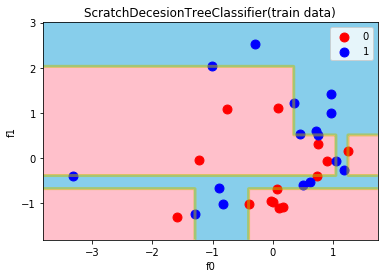

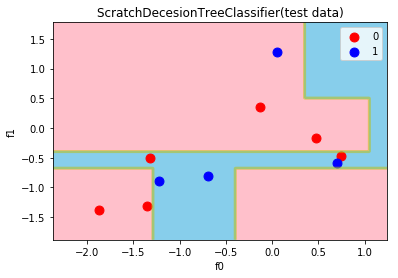

In [27]:
# 可視化
# 学習用データ
decision_region(X_train_std, y_train, stree, 
                title='ScratchDecesionTreeClassifier(train data)',
                            xlabel='f0', ylabel='f1', target_names=['0', '1'])

# 検証用データ
decision_region(X_test_std, y_test, stree, 
                            title='ScratchDecesionTreeClassifier(test data)',
                            xlabel='f0', ylabel='f1', target_names=['0', '1'])

sklearn

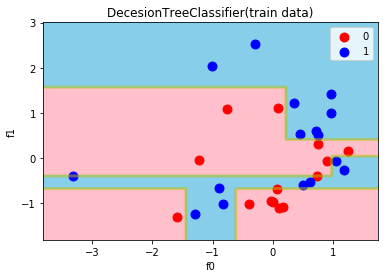

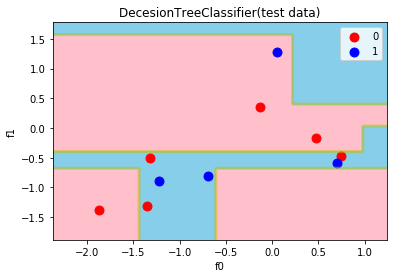

In [28]:
# 可視化
# 学習用データ
decision_region(X_train_std, y_train, tree, 
                title='DecesionTreeClassifier(train data)',
                            xlabel='f0', ylabel='f1', target_names=['0', '1'])

# 検証用データ
decision_region(X_test_std, y_test, tree, 
                            title='DecesionTreeClassifier(test data)',
                            xlabel='f0', ylabel='f1', target_names=['0', '1'])

今回のデータセットはランダムに分布しているデータだったので、スクラッチしたクラスとsklearnのモデルを比較すると、精度には多少差があったが、決定境界は似た形になった。若干の誤差は、しきい値の取り方によるものではないかと感じた。

## 【問題8】 決定木の利用場面

最終発表時に以下の内容についてディスカッションを行います。自分なりの意見を用意しておいてください。
- 決定木が他の手法に比べて有効だと考えられるのはどういった場面か

注意点   
答えがある問いではありません。いろいろな視点から見て理解を深めていきましょう。

**Answer**  
決定木は木の枝が分かれていくようなイメージであるため、可視化しやすく、可読性が高い。そのため、機械学習を知らない人に対しても説明しやすいところが有効と思われる。